In [1]:
from itertools import cycle
import pickle
import sys
import time
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import sklearn.preprocessing
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import LSTM, Bidirectional, BatchNormalization, Convolution1D, MaxPooling1D, Reshape
from tensorflow.keras.models import Sequential

%matplotlib inline

In [2]:
!wget https://github.com/fisher85/ml-cybersecurity/blob/master/python-web-attack-detection/datasets/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv.zip?raw=true -O dataset.zip
!unzip -u dataset.zip

--2022-12-12 02:29:30--  https://github.com/fisher85/ml-cybersecurity/blob/master/python-web-attack-detection/datasets/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv.zip?raw=true
Resolving github.com (github.com)... 20.207.73.82
Connecting to github.com (github.com)|20.207.73.82|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/fisher85/ml-cybersecurity/raw/master/python-web-attack-detection/datasets/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv.zip [following]
--2022-12-12 02:29:31--  https://github.com/fisher85/ml-cybersecurity/raw/master/python-web-attack-detection/datasets/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fisher85/ml-cybersecurity/master/python-web-attack-detection/datasets/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv.zip [following]
--2022-12-

  4900K .......... .......... .......... .......... .......... 32% 20.3M 5s
  4950K .......... .......... .......... .......... .......... 33% 1.36M 5s
  5000K .......... .......... .......... .......... .......... 33% 8.25M 5s
  5050K .......... .......... .......... .......... .......... 33% 21.8M 5s
  5100K .......... .......... .......... .......... .......... 34% 8.47M 5s
  5150K .......... .......... .......... .......... .......... 34% 8.85M 5s
  5200K .......... .......... .......... .......... .......... 34% 8.62M 5s
  5250K .......... .......... .......... .......... .......... 35% 22.8M 5s
  5300K .......... .......... .......... .......... .......... 35% 9.35M 5s
  5350K .......... .......... .......... .......... .......... 35% 4.66M 5s
  5400K .......... .......... .......... .......... .......... 36% 2.58M 5s
  5450K .......... .......... .......... .......... .......... 36% 5.12M 5s
  5500K .......... .......... .......... .......... .......... 36% 21.6M 5s
  5550K ....

Archive:  dataset.zip
  inflating: Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv  


In [3]:
df = pd.read_csv('Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', engine='python', encoding='cp1252')

In [4]:
with open('Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv') as csv_file:

  list_of_column_names = []

  for row in csv_file:
    list_of_column_names.append(row)
    break

  print("List of column names : ",
    list_of_column_names[0])

List of column names :  Flow ID, Source IP, Source Port, Destination IP, Destination Port, Protocol, Timestamp, Flow Duration, Total Fwd Packets, Total Backward Packets,Total Length of Fwd Packets, Total Length of Bwd Packets, Fwd Packet Length Max, Fwd Packet Length Min, Fwd Packet Length Mean, Fwd Packet Length Std,Bwd Packet Length Max, Bwd Packet Length Min, Bwd Packet Length Mean, Bwd Packet Length Std,Flow Bytes/s, Flow Packets/s, Flow IAT Mean, Flow IAT Std, Flow IAT Max, Flow IAT Min,Fwd IAT Total, Fwd IAT Mean, Fwd IAT Std, Fwd IAT Max, Fwd IAT Min,Bwd IAT Total, Bwd IAT Mean, Bwd IAT Std, Bwd IAT Max, Bwd IAT Min,Fwd PSH Flags, Bwd PSH Flags, Fwd URG Flags, Bwd URG Flags, Fwd Header Length, Bwd Header Length,Fwd Packets/s, Bwd Packets/s, Min Packet Length, Max Packet Length, Packet Length Mean, Packet Length Std, Packet Length Variance,FIN Flag Count, SYN Flag Count, RST Flag Count, PSH Flag Count, ACK Flag Count, URG Flag Count, CWE Flag Count, ECE Flag Count, Down/Up Ratio,

In [5]:
df = df.drop(df[pd.isnull(df['Flow ID'])].index)
df.shape

(170366, 85)

In [6]:
df.replace([np.inf, -np.inf, np.nan], -1, inplace=True)

In [7]:
!wget https://github.com/fisher85/ml-cybersecurity/blob/master/python-web-attack-detection/datasets/web_attacks_balanced.zip?raw=true -O dataset.zip
!unzip -u dataset.zip

--2022-12-12 02:30:46--  https://github.com/fisher85/ml-cybersecurity/blob/master/python-web-attack-detection/datasets/web_attacks_balanced.zip?raw=true
Resolving github.com (github.com)... 20.207.73.82
Connecting to github.com (github.com)|20.207.73.82|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/fisher85/ml-cybersecurity/raw/master/python-web-attack-detection/datasets/web_attacks_balanced.zip [following]
--2022-12-12 02:30:47--  https://github.com/fisher85/ml-cybersecurity/raw/master/python-web-attack-detection/datasets/web_attacks_balanced.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fisher85/ml-cybersecurity/master/python-web-attack-detection/datasets/web_attacks_balanced.zip [following]
--2022-12-12 02:30:48--  https://raw.githubusercontent.com/fisher85/ml-cybersecurity/master/python-web-attack-detection/datasets/web_attacks_balan

Archive:  dataset.zip
  inflating: web_attacks_balanced.csv  


In [8]:
data = pd.read_csv('web_attacks_balanced.csv', delimiter=',')

y = data['Label']
X = data.drop(labels=['Label', 'Flow ID', 'Source IP', 'Source Port',
              'Destination IP', 'Destination Port', 'Protocol', 'Timestamp'], axis=1)



In [9]:
#deleting any null values to get better accuracy
X.isnull().values.any()

y.isnull().values.any()

False

In [10]:
X

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,76978.0,2.0,2.0,78.0,206.0,39.0,39.0,39.0,0.0,103.0,...,1.0,32.0,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0
1,78120.0,2.0,2.0,78.0,206.0,39.0,39.0,39.0,0.0,103.0,...,1.0,32.0,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0
2,205.0,2.0,2.0,64.0,158.0,32.0,32.0,32.0,0.0,79.0,...,1.0,32.0,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0
3,169.0,2.0,2.0,102.0,224.0,51.0,51.0,51.0,0.0,112.0,...,1.0,32.0,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0
4,297.0,2.0,2.0,102.0,224.0,51.0,51.0,51.0,0.0,112.0,...,1.0,32.0,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7262,3.0,2.0,0.0,12.0,0.0,6.0,6.0,6.0,0.0,0.0,...,1.0,20.0,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0
7263,110225.0,1.0,1.0,54.0,132.0,54.0,54.0,54.0,0.0,132.0,...,0.0,20.0,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0
7264,119994187.0,83.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4397194.167,7971475.641,19900000.0,65.0,10400000.0,4150499.041,19300000.0,5960934.0
7265,45557.0,2.0,2.0,60.0,264.0,30.0,30.0,30.0,0.0,132.0,...,1.0,20.0,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0


In [11]:
y

0       BENIGN
1       BENIGN
2       BENIGN
3       BENIGN
4       BENIGN
         ...  
7262    BENIGN
7263    BENIGN
7264    BENIGN
7265    BENIGN
7266    BENIGN
Name: Label, Length: 7267, dtype: object

In [12]:
scaler = sklearn.preprocessing.MinMaxScaler()

In [13]:
batch_size = 32
model = Sequential()
model.add(Convolution1D(64, kernel_size=32, padding="same",
          activation="relu", input_shape=(76, 1)))
model.add(MaxPooling1D(pool_size=(5)))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Reshape((128, 1), input_shape=(128, )))

model.add(MaxPooling1D(pool_size=(5)))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(128, return_sequences=False)))

model.add(Dropout(0.5))
model.add(Dense(4))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

In [14]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [15]:
acc = pd.DataFrame(columns=[1, 2, 3, 4, 5, 'Mean'], index=['Accuracy', 'Precision', 'Recall', 'F1'])

In [16]:
def print_metrics(y_eval: np.ndarray, y_pred: np.ndarray, average: str = 'binary') -> List[float]:
    accu = metrics.accuracy_score(y_eval, y_pred)
    prec = metrics.precision_score(y_eval, y_pred, average=average)
    recall = metrics.recall_score(y_eval, y_pred, average=average)
    f1 = metrics.f1_score(y_eval, y_pred, average=average)

    print('Accuracy =', accu)
    print('Precision =', prec)
    print('Recall =', recall)
    print('F1 =', f1)

    return [acc, prec, recall, f1]

In [17]:
actual_val = np.empty([0], dtype=float)
pred_val = np.empty([0], dtype=float)

In [18]:

def model_fitting(model: Sequential,
                       X: pd.DataFrame,
                       y: pd.Series,
                       train_index: np.ndarray,
                       test_index: np.ndarray,
                       scaler: sklearn.preprocessing.MinMaxScaler) -> Tuple[np.ndarray, np.ndarray]:
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]


    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)

   
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    
    y_train_encoded = pd.get_dummies(y_train).values
    y_test_encoded = pd.get_dummies(y_test).values


    model.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded), epochs=10)

   
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_eval = np.argmax(y_test_encoded, axis=1)

    return y_eval, y_pred


In [19]:
with tf.device('/CPU:0'):
  start_time = time.time()

  x=1

  for train_index, test_index in cv.split(X, y):
        y_eval, y_pred = model_fitting(
            model, X, y, train_index, test_index, scaler)
        
        actual_val = np.append(actual_val, y_eval)
        pred_val = np.append(pred_val, y_pred)
       
        print("Validation scores:")
        acc[x] = print_metrics(y_eval, y_pred, average='weighted')
        x += 1

    # Get the learning time.
  print('Total processing time is ', time.time() - start_time,  'seconds')

Epoch 1/10
182/182 [==============================] - 30s 82ms/step - loss: 0.3839 - accuracy: 0.8416 - val_loss: 1.2263 - val_accuracy: 0.7001
Epoch 2/10
182/182 [==============================] - 13s 70ms/step - loss: 0.2930 - accuracy: 0.8682 - val_loss: 2.8584 - val_accuracy: 0.7001
Epoch 3/10
182/182 [==============================] - 12s 64ms/step - loss: 0.2799 - accuracy: 0.8775 - val_loss: 2.0636 - val_accuracy: 0.7098
Epoch 4/10
182/182 [==============================] - 12s 65ms/step - loss: 0.2882 - accuracy: 0.8706 - val_loss: 0.3875 - val_accuracy: 0.8563
Epoch 5/10
182/182 [==============================] - 13s 72ms/step - loss: 0.2684 - accuracy: 0.8772 - val_loss: 0.2887 - val_accuracy: 0.8604
Epoch 6/10
182/182 [==============================] - 12s 66ms/step - loss: 0.2639 - accuracy: 0.8801 - val_loss: 0.2493 - val_accuracy: 0.8879
Epoch 7/10
182/182 [==============================] - 11s 63ms/step - loss: 0.2655 - accuracy: 0.8773 - val_loss: 0.2478 - val_accuracy:

C:\Users\Sebastain\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


182/182 [==============================] - 13s 70ms/step - loss: 0.2433 - accuracy: 0.8856 - val_loss: 2.0672 - val_accuracy: 0.7221
Epoch 2/10
182/182 [==============================] - 11s 62ms/step - loss: 0.2460 - accuracy: 0.8863 - val_loss: 1.7721 - val_accuracy: 0.7132
Epoch 3/10
182/182 [==============================] - 12s 64ms/step - loss: 0.2469 - accuracy: 0.8853 - val_loss: 0.7524 - val_accuracy: 0.7208
Epoch 4/10
182/182 [==============================] - 11s 59ms/step - loss: 0.2546 - accuracy: 0.8846 - val_loss: 0.4517 - val_accuracy: 0.8810
Epoch 5/10
182/182 [==============================] - 11s 59ms/step - loss: 0.2449 - accuracy: 0.8866 - val_loss: 0.5909 - val_accuracy: 0.8363
Epoch 6/10
182/182 [==============================] - 11s 63ms/step - loss: 0.2396 - accuracy: 0.8878 - val_loss: 0.6645 - val_accuracy: 0.7215
Epoch 7/10
182/182 [==============================] - 11s 58ms/step - loss: 0.2404 - accuracy: 0.8892 - val_loss: 0.4734 - val_accuracy: 0.8796
Epo

C:\Users\Sebastain\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


182/182 [==============================] - 11s 59ms/step - loss: 0.2396 - accuracy: 0.8868 - val_loss: 0.7731 - val_accuracy: 0.7213
Epoch 2/10
182/182 [==============================] - 11s 58ms/step - loss: 0.2359 - accuracy: 0.8925 - val_loss: 2.4657 - val_accuracy: 0.6999
Epoch 3/10
182/182 [==============================] - 10s 58ms/step - loss: 0.2298 - accuracy: 0.8923 - val_loss: 1.6921 - val_accuracy: 0.7199
Epoch 4/10
182/182 [==============================] - 11s 58ms/step - loss: 0.2344 - accuracy: 0.8896 - val_loss: 0.5051 - val_accuracy: 0.8782
Epoch 5/10
182/182 [==============================] - 11s 59ms/step - loss: 0.2327 - accuracy: 0.8925 - val_loss: 3.0804 - val_accuracy: 0.7199
Epoch 6/10
182/182 [==============================] - 11s 58ms/step - loss: 0.2328 - accuracy: 0.8910 - val_loss: 3.8955 - val_accuracy: 0.7213
Epoch 7/10
182/182 [==============================] - 11s 59ms/step - loss: 0.2323 - accuracy: 0.8908 - val_loss: 4.0734 - val_accuracy: 0.7103
Epo

C:\Users\Sebastain\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


182/182 [==============================] - 11s 60ms/step - loss: 0.2283 - accuracy: 0.8949 - val_loss: 0.3737 - val_accuracy: 0.8796
Epoch 2/10
182/182 [==============================] - 11s 62ms/step - loss: 0.2677 - accuracy: 0.8854 - val_loss: 0.3781 - val_accuracy: 0.8741
Epoch 3/10
182/182 [==============================] - 12s 65ms/step - loss: 0.2343 - accuracy: 0.8934 - val_loss: 0.3673 - val_accuracy: 0.8858
Epoch 4/10
182/182 [==============================] - 11s 60ms/step - loss: 0.2316 - accuracy: 0.8923 - val_loss: 0.3736 - val_accuracy: 0.8761
Epoch 5/10
182/182 [==============================] - 10s 57ms/step - loss: 0.2288 - accuracy: 0.8956 - val_loss: 0.3863 - val_accuracy: 0.8830
Epoch 6/10
182/182 [==============================] - 10s 57ms/step - loss: 0.2322 - accuracy: 0.8940 - val_loss: 0.3600 - val_accuracy: 0.8830
Epoch 7/10
182/182 [==============================] - 11s 60ms/step - loss: 0.2279 - accuracy: 0.8973 - val_loss: 0.3706 - val_accuracy: 0.8802
Epo

C:\Users\Sebastain\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
def plot_confusion_matrix(y_eval: np.ndarray, y_pred: np.ndarray, labels: List[str]) -> None:
 
    confusion_matrix = metrics.confusion_matrix(y_eval, y_pred)

    # Evaluate accuracy and misclassification scores.
    accuracy = np.trace(confusion_matrix) / float(np.sum(confusion_matrix))
    misclass = 1 - accuracy

    # Plot the confusion matrix.
    metrics.ConfusionMatrixDisplay.from_predictions(
        y_eval, y_pred, display_labels=labels,
        xticks_rotation='vertical', cmap='Purples')
    plt.xlabel('Predicted label\n\naccuracy={:0.4f}; misclass={:0.4f}'.format(
        accuracy, misclass))
    plt.title('Confusion Matrix')
    plt.show()

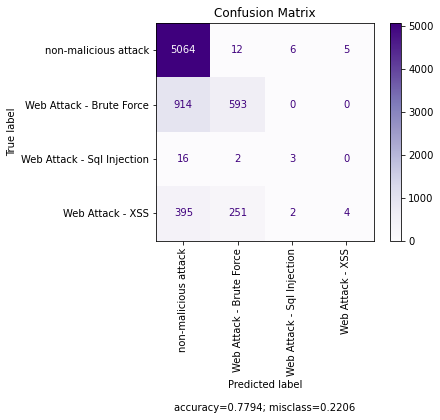

In [21]:
plot_confusion_matrix(actual_val, pred_val, ['non-malicious attack', 'Web Attack - Brute Force', 'Web Attack - Sql Injection', 'Web Attack - XSS'])